## Analyzer for Elisa's 3P1F and 2P2F event lists and for CJLST NTuples.

In [ ]:
# Execute `voms-proxy-init` in the shell before starting this JupyNB.
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from collections import Counter
from ROOT import TFile, TCanvas, gStyle

# import uproot
# import pandas as pd

# from Utils_Python.Utils_Files import check_overwrite
from sidequests.data.cjlst_fw import CjlstFlag
from Utils_Python.Commands import shell_cmd
from Utils_Python.Utils_Files import save_to_json, open_json

In [ ]:
infile_matteo_data2018 = "/eos/cms/store/group/phys_higgs/cmshzz4l/cjlst/RunIILegacy/200430_LegacyRun2/Data_2018/AllData/ZZ4lAnalysis.root"
t_matteo_up = uproot.open(f"root://eoscms.cern.ch/{infile_matteo_data2018}:CRZLLTree/candTree", timeout=180)

runnum_arr = t_matteo_up["RunNumber"].array(library="np")

In [ ]:
def write_tree_info_to_txt(infile, outtxt, keep_2P2F=True, keep_3P1F=True):
    """Write info from TFile `infile` from TTree 'passedEvents' to `outtxt`.

    Info which gets written:
    Run : LumiSect : Event
    """
    tfile = rt.TFile.Open(infile)
    tree = tfile.Get("passedEvents")

    with open(outtxt, "w") as f:
        f.write("# Run : LumiSect : Event\n")
        for evt in tree:
            keep_evt = True if (keep_2P2F and evt.getis2P2F) or (keep_3P1F and evt.is3P1F) else False
            if keep_evt:
                f.write(f"{evt.Run} : {evt.LumiSect} : {evt.Event}\n")
    print(f"TTree info written to:\n{outtxt}")

def get_list_of_lines(evt_ls_txt):
    """
    Return a list of the lines from `evt_ls_txt`.
    The lines must start with a digit.
    Trailing newlines ('\\n') are stripped.
    """
    with open(evt_ls_txt, "r") as f:
        return [line.rstrip('\n') for line in f.readlines() if line[0].isdigit()]

def get_list_of_tuples(evt_ls):
    """
    Return a list of 3-tuples from a list of strings `evt_ls`:

    [
        (Run1, LumiSect1, Event1),
        (Run2, LumiSect2, Event2),
        ...
    ]
    """
    new_evt_ls = []
    for line in evt_ls:
        tup = tuple([int(num) for num in line.split(":")[:3]])
        new_evt_ls.append(tup)
    return new_evt_ls

def print_evt_info_bbf(tree):
    print(f"tree.passedFullSelection: {tree.passedFullSelection}")
    print(f"tree.passedZXCRSelection: {tree.passedZXCRSelection}")
    print(f"tree.nZXCRFailedLeptons: {tree.nZXCRFailedLeptons}")
    print(f"tree.lep_Hindex: {list(tree.lep_Hindex)}")
    print(f"tree.lepFSR_pt: {list(tree.lepFSR_pt)}")
    print(f"tree.lep_RelIso: {list(tree.lep_RelIso)}")
    print(f"tree.lep_id: {list(tree.lep_id)}")
    print(f"tree.lep_tightId: {list(tree.lep_tightId)}")
    print("#--- PRINT MORE Z AND H INFO HERE. ---#")

def print_evt_info_cjlst(tree):
    print(f"tree.LepPt: {list(tree.LepPt)}")
    print(f"tree.LepLepId: {list(tree.LepLepId)}")
    print(f"tree.LepisID (tight lep): {list(np.array(tree.LepisID, dtype=bool))}")
    print(f"tree.LepisID (tight lep): {list(np.array(tree.LepisID, dtype=bool))}")
    print(f"tree.CRflag: {tree.CRflag} -> {CjlstFlag(tree.CRflag).name}")
    print(f"tree.Z1Mass: {tree.Z1Mass}")
    print(f"tree.Z2Mass: {tree.Z2Mass}")
    print(f"tree.ZZMass: {tree.ZZMass}")
    print()

def analyze_single_evt(tree, run, lumi, event, fw="bbf", which="all", evt_start=0, print_every=10000):
    """Print out event info (`run`:`lumi`:`event`) found in `tree`.
    
    Parameters
    ----------
    fw : str
        Which framework to use: "bbf", "cjlst"
    which : str
        Which instance of the event you want to select.
        Options: "first", anything else prints all such events.
    evt_start : int
    """
    print(f"Searching for event ID {run}:{lumi}:{event} in {fw.upper()} framework")

    n_tot = tree.GetEntries()
    for evt_num in range(evt_start, n_tot):
        tree.GetEntry(evt_num)
        if (evt_num % print_every) == 0:
            print(f"Event {evt_num}/{n_tot}")

        if fw in "bbf":
            if tree.Run != run:
                continue
            if tree.LumiSect != lumi:
                continue
            if tree.Event != event:
                continue
            if not tree.passedZXCRSelection:
                print(f"[WARNING] Event has passedZXCRSelection == 0.")
            print(f"Event {run}:{lumi}:{event} found. Index: {evt_num}")
            print_evt_info_bbf(tree)

        elif fw in "cjlst":
            if tree.RunNumber != run:
                continue
            if tree.LumiNumber != lumi:
                continue
            if tree.EventNumber != event:
                continue
            print(f"Event {run}:{lumi}:{event} found. Index: {evt_num}")
            print_evt_info_cjlst(tree)

        if "first" in which:
            break
    print("Done.")

def get_control_region(evt):
    """Return str of control region based on `lep_Hindex` and `lep_tightId`.

    Only works for BBF root files.
    """
    l_Hindex_ls = list(evt.lep_Hindex)
    assert -1 not in l_Hindex_ls
    l_tightId_arr = np.array(evt.lep_tightId)[l_Hindex_ls]

    # 3P1F is defined as 3 leptons passing tight and ISO criteria:
    l_RelIsoNoFSR_arr = np.array(evt.lep_RelIsoNoFSR)[l_Hindex_ls]
    # muons_arr = 
    # l_RelIsoNoFSR_arr
    s = l_tightId_arr.sum()

    if s == 4:
        return "SR"
    elif s == 3:
        return "3P1F"
    elif s == 2:
        return "2P2F"
    else:
        return f"[WARNING] Could not assign number of tight leps ({s}) to a CR!"

In [ ]:
class FileComparer:

    def __init__(self, txt_file1, txt_file2, control_reg="", verbose=False):
        """
        Feed in two txt files to be compared.

        NOTE:
        - Each txt file is converted to a list of 3-tuples and stored.
        - Only lines which begin with a digit are read and stored.

        Parameters
        ----------
        control_reg : str
            Used for printing and writing files.
        """
        self.file1 = txt_file1
        self.file2 = txt_file2
        self.cr = control_reg
        self.verbose = verbose

        self.check_cr(txt_file1, txt_file2)
        if control_reg in "":
            self.cr = "all"
        self.ls_of_tup_file1_nodup = None
        self.ls_of_tup_file2_nodup = None

        # Check for duplicates.
        self.ls_of_tup_file1 = get_list_of_tuples(get_list_of_lines(txt_file1))
        if self.check_for_dups(txt_file1, self.ls_of_tup_file1):
            # Remove duplicates by turning to a set and then back to list.
            self.ls_of_tup_file1_nodup = list(set(self.ls_of_tup_file1))
        else:
            self.ls_of_tup_file1_nodup = self.ls_of_tup_file1

        self.ls_of_tup_file2 = get_list_of_tuples(get_list_of_lines(txt_file2))
        if self.check_for_dups(txt_file2, self.ls_of_tup_file2):
            self.ls_of_tup_file2_nodup = list(set(self.ls_of_tup_file2))
        else:
            self.ls_of_tup_file2_nodup = self.ls_of_tup_file2

        self.compare_files()

    def check_for_dups(self, txt_file, ls_of_tup):
        """Return True and print info if duplicates within a file are found."""
        len_ls = len(ls_of_tup)
        len_set = len(set(ls_of_tup))
        if len_ls != len_set:
            n_dups = len_ls - len_set
            print(f"[WARNING] Duplicates ({n_dups}) found in file: {txt_file}")
            print(f"[WARNING] len(ls)={len_ls} != len(set)={len_set}")
            if self.verbose:
                # There's some counting error here...
                # I know there are 120 duplicates, but counter only finds 118.
                counter = Counter(ls_of_tup)
                print(f"Printing duplicates in file:\n{txt_file}")
                dup_key_ls = [k for k,v in counter.items() if v > 1]
                # pprint(dup_key_ls)
                # assert n_dups == len(dup_key_ls)
                pprint(dup_key_ls)
            return True
        return False

    def check_cr(self, path1, path2):
        """Make sure that the control region is the one requested."""
        cr_low = self.cr.lower()
        assert cr_low in ("2p2f", "3p1f", "")
        # Make sure that the two files have the requested CR.
        msg = f"The `control_reg` ({self.cr}) not found in names of txt files."
        assert all(cr_low in f.lower() for f in (path1, path2)), msg

    def compare_files(self):
        """Store unique and common info about files. Called when instantiated."""
        self.set_common_to_both = set(self.ls_of_tup_file1_nodup) & set(self.ls_of_tup_file2_nodup)
        self.set_unique_to_file1 = set(self.ls_of_tup_file1_nodup) - set(self.ls_of_tup_file2_nodup)
        self.set_unique_to_file2 = set(self.ls_of_tup_file2_nodup) - set(self.ls_of_tup_file1_nodup)

    def print_results(self, whose="all", show_n_evts=25, save_to_file=None):
        """Print info describing differences between two files.
        
        Parameters
        ----------
        whose : str
            "file1", "file2", "all"
        """
        print(f"Comparing {self.cr.upper()}:")
        print(f"file1: {self.file1}")
        print(f"file2: {self.file2}")

        print(f"{'n_evts total file1 (no dup): ':<25}{len(self.ls_of_tup_file1_nodup)}")
        print(f"{'n_evts total file2 (no dup): ':<25}{len(self.ls_of_tup_file2_nodup)}")
        print(f"{'n_evts in common: ':<25}{len(self.set_common_to_both)}")
        print(f"{'n_evts unique to file1: ':<25}{len(self.set_unique_to_file1)}")
        print(f"{'n_evts unique to file2: ':<25}{len(self.set_unique_to_file2)}")

        header = "#-- Run -- LumiSect -- Event --#"
        if show_n_evts == -1:
            show_n_evts = None
        if whose in ("file1", "all"):
            print(f"  file1's unique events:")
            print(header)
            pprint(list(self.set_unique_to_file1)[:show_n_evts])
            print()
        if whose in ("file2", "all"):
            print(f"  file2's unique events:")
            print(header)
            pprint(list(self.set_unique_to_file2)[:show_n_evts])
            print()

    def save_events_to_txt(self, kind, outtxt, no_dup=True, overwrite=False):
        """
        Write the events to `outtxt` in the format:

        Run : LumiSect : Event

        Parameters
        ----------
        kind : str
            Choose which events to write to `outtxt`.
            "file1", "file2", "common", "file1_unique", "file2_unique"
        """
        check_overwrite(outtxt, overwrite=overwrite)
        assert kind in ("file1", "file2", "common", "file1_unique", "file2_unique")

        if kind in "file1":
            iter_ls_of_tup = self.ls_of_tup_file1_nodup if no_dup else self.ls_of_tup_file1
        elif kind in "file2":
            iter_ls_of_tup = self.ls_of_tup_file2_nodup if no_dup else self.ls_of_tup_file2
        elif kind in "common":
            iter_ls_of_tup = self.set_common_to_both
        elif kind in "file1_unique":
            iter_ls_of_tup = self.set_unique_to_file1
        elif kind in "file2_unique":
            iter_ls_of_tup = self.set_unique_to_file2

        with open(outtxt, "w") as f:
            f.write("# Run : LumiSect : Event\n")
            for tup in iter_ls_of_tup:
                f.write(f"{tup[0]} : {tup[1]} : {tup[2]}\n")
            print(f"Wrote '{self.cr} {kind}' events to file:\n{outtxt}")

In [ ]:
# infile_jake_tree = "/blue/avery/rosedj1/ZplusXpython/data/ZLL_CR_FRapplied/Data_2018_NoDuplicates_RunEventLumi.root"
infile_jake_tree = "/blue/avery/rosedj1/ZplusXpython/data/ZLL_CR_FRapplied/new_data2018/cr_ZLL.root"
# ^Contains all the passedZXCRSelection events as in:
# /fullstats/ZL_ZLL_4P_CR/noduplicates/Data2018_NoDuplicates.root

#####################
#--- CJLST files ---#
#####################
infile_elisa       = "/blue/avery/rosedj1/ZplusXpython/sidequests/findmissingevents_comparetoelisa/CRLLos_listOfEvents.txt"
infile_elisa_2p2f  = "/blue/avery/rosedj1/ZplusXpython/sidequests/findmissingevents_comparetoelisa/CRLLos_2P2F_listOfEvents.txt"
infile_elisa_3p1f  = "/blue/avery/rosedj1/ZplusXpython/sidequests/findmissingevents_comparetoelisa/CRLLos_3P1F_listOfEvents.txt"
infile_matteo_data2018 = "/eos/cms/store/group/phys_higgs/cmshzz4l/cjlst/RunIILegacy/200430_LegacyRun2/Data_2018/AllData/ZZ4lAnalysis.root"
infile_cjlst_sr = "/blue/avery/rosedj1/ZplusXpython/sidequests/data/2018_CJLST_finalSelectedEvents_SR.txt"

# elisa_3p1f_unique_evtid_dct_json = "/blue/avery/rosedj1/ZplusXpython/sidequests/findmissingevents_comparetoelisa/elisa_3p1f_unique_evtID_CR_dct.json"
elisa_3p1f_unique_evtid_dct_json = "/cmsuf/data/store/user/t2/users/rosedj1/ZplusXpython/sidequests/data/json/elisa_3p1f_unique_evtID_CR_dct.json"


outdir = "/blue/avery/rosedj1/ZplusXpython/sidequests/findmissingevents_comparetoelisa/jakes_new2018data/"

infile_jake      = os.path.join(outdir, "CRLLos_listOfEvents_jake.txt")
infile_jake_2p2f = os.path.join(outdir, "CRLLos_listOfEvents_jake_2P2F.txt")
infile_jake_3p1f = os.path.join(outdir, "CRLLos_listOfEvents_jake_3P1F.txt")
# infile_elisa_unique_353 = "/blue/avery/rosedj1/ZplusXpython/sidequests/rootfiles/elisa_unique_353events.root"
infile_elisa_unique_353 = "/cmsuf/data/store/user/t2/users/rosedj1/ZplusXpython/sidequests/rootfiles/elisa_unique_353events.root"

outfile_elisa_2p2f_unique  = os.path.join(outdir, "CRLLos_2P2F_listOfEvents_unique.txt")
outfile_elisa_3p1f_unique  = os.path.join(outdir, "CRLLos_3P1F_listOfEvents_unique.txt")
outfile_jake_2p2f_unique = os.path.join(outdir, "CRLLos_listOfEvents_jake_2P2F_unique.txt")
outfile_jake_3p1f_unique = os.path.join(outdir, "CRLLos_listOfEvents_jake_3P1F_unique.txt")
outfile_LLR_data2018 = "/blue/avery/rosedj1/ZplusXpython/sidequests/findmissingevents_comparetoelisa/"

outfile_2p2f_common = os.path.join(outdir, "CRLLos_listOfEvents_2P2F_common.txt")
outfile_3p1f_common = os.path.join(outdir, "CRLLos_listOfEvents_3P1F_common.txt")
# write_tree_info_to_txt(infile_jake_tree, infile_jake)

## Make txt files of events.

In [ ]:
write_tree_info_to_txt(infile_jake_tree, infile_jake_2p2f, keep_2P2F=True, keep_3P1F=False)
write_tree_info_to_txt(infile_jake_tree, infile_jake_3p1f, keep_2P2F=False, keep_3P1F=True)

## Compare files.

### fc_elisa_2p2fvs3p1f = FileComparer(infile_elisa_2p2f, infile_elisa_3p1f)

In [ ]:
fc_jakevselisa_3p1f = FileComparer(infile_jake_3p1f, infile_elisa_3p1f, control_reg="3p1f", verbose=True)
fc_jakevselisa_2p2f = FileComparer(infile_jake_2p2f, infile_elisa_2p2f, control_reg="2p2f", verbose=True)
fc_jakevselisa_all  = FileComparer(infile_jake, infile_elisa, control_reg="", verbose=True)

# fc_jakevselisa_3p1f.print_results(whose="file1", show_n_evts=5)
# fc_jakevselisa_3p1f.print_results(whose="file2", show_n_evts=5)
# fc_jakevselisa_2p2f.print_results(whose="file1", show_n_evts=5)
# fc_jakevselisa_2p2f.print_results(whose="file2", show_n_evts=5)
# # fc_jakevselisa_all.print_results(whose="all", show_n_evts=10)

# # Write the events to txt.
# overwrite = 0
# fc_jakevselisa_3p1f.save_events_to_txt(kind="file1_unique", outtxt=outfile_jake_3p1f_unique, no_dup=True, overwrite=overwrite)
# fc_jakevselisa_3p1f.save_events_to_txt(kind="file2_unique", outtxt=outfile_elisa_3p1f_unique, no_dup=True, overwrite=overwrite)
# fc_jakevselisa_3p1f.save_events_to_txt(kind="common", outtxt=outfile_3p1f_common, no_dup=True, overwrite=overwrite)

# fc_jakevselisa_2p2f.save_events_to_txt(kind="file1_unique", outtxt=outfile_jake_2p2f_unique, no_dup=True, overwrite=overwrite)
# fc_jakevselisa_2p2f.save_events_to_txt(kind="file2_unique", outtxt=outfile_elisa_2p2f_unique, no_dup=True, overwrite=overwrite)
# fc_jakevselisa_2p2f.save_events_to_txt(kind="common", outtxt=outfile_2p2f_common, no_dup=True, overwrite=overwrite)

In [ ]:
len(fc_jakevselisa_all.ls_of_tup_file2) - len(fc_jakevselisa_all.ls_of_tup_file2_nodup)

In [ ]:
# Make a manual counter.
# Print out events which appear more than once in fc_jakevselisa_all.ls_of_tup_file2.
for f in fc_jakevselisa_all.ls_of_tup_file2:
    ct = 0
    if f in fc_jakevselisa_all.ls_of_tup_file2_nodup:
        if ct == 5: break
        print(f)
# Identify the 2 events from 120 which didn't appear in 118.
# Why did counter not find them?

## LLR Group's (diff. xs) RedBkg Files

Vukasin pointed me to their root files:

- `/afs/cern.ch/user/v/vmilosev/public/forJake/new_ZX_LLR/AllData*`

Let's have a look.

In [ ]:
infile_llr_2018 = "/blue/avery/rosedj1/ZplusXpython/sidequests/data/LLR_redbkg/AllData_ZX_redTree_2018.root"

f_llr = TFile(infile_llr_2018)
t_llr = f_llr.Get("SelectedTree")

odd_event = (315488, 152, 135937874, )

n_tot_evts = t_llr.GetEntries()
for evt_num, evt in enumerate(t_llr):
    if (evt_num % 500) == 0:
        print(f"Checking event #{evt_num}/{n_tot_evts}")
    if evt.RunNumber != odd_event[0]:
        continue
    if evt.LumiNumber != odd_event[1]:
        continue
    if evt.EventNumber != odd_event[2]:
        continue
    print(f"Event found ({evt.RunNumber}:{evt.LumiNumber}:{evt.EventNumber}) at index {evt_num}")
    break

In [ ]:
list(t.GetListOfBranches())

t.Scan("htxs_stage1_red_cat:htxs_stage1_red_catName:htxs_stage1_red_prod_cat:htxs_stage1_red_prod_catName")

#--- Counting instances of htxs_stage1 ---#
# htxs_stage1_red_catName_ls = [str(evt.htxs_stage1_red_catName) for evt in t if evt.htxs_stage1_red_catName == 'ZX']
# count_ZX_str = Counter(htxs_stage1_red_catName_ls)
htxs_stage1_red_cat_ls = [str(evt.htxs_stage1_red_cat) for evt in t if evt.htxs_stage1_red_cat == -2]
count_ZX_cat = Counter(htxs_stage1_red_cat_ls)
# dup_key_ls = [k for k,v in counter.items() if v > 1]
print(count_ZX_cat)

t.GetEntries()  # 12331

#--- Tried to match any of Elisa's ZLL events to diff. xs group's events.
#--- None matched.
elisa_evtid_2p2f_tup = get_list_of_tuples(get_list_of_lines(infile_elisa_2p2f))
n_tot_tup = len(elisa_evtid_2p2f_tup)
start_at = 1000
for num_tup, tup in enumerate(elisa_evtid_2p2f_tup[start_at:], start_at):
    if (num_tup % 1000) == 0:
        print(f"Checking tuple #{num_tup}/{n_tot_tup}")
    for evt_num, evt in enumerate(t):
        if evt.RunNumber != elisa_evtid_2p2f_tup_example[0]:
            continue
        if evt.LumiNumber != elisa_evtid_2p2f_tup_example[1]:
            continue
        if evt.EventNumber != elisa_evtid_2p2f_tup_example[2]:
            continue
        print(f"Event {evt_num}, {evt.RunNumber}:{evt.LumiNumber}:{evt.EventNumber}")
        break

## Conclusion

These are Diff. XS Group's SR samples.
They do not contain RedBkg info.

### So What Next?

Matteo gave me a CJLST 2018 Data NTuple to look at.

Let's have a look.

### Verify duplicate.


In [ ]:
# Count the number of 3P1F, 2P2F, and SS events in CJLST NTuples:
for c in CjlstFlag:
    conreg = c.name
    n = t_matteo.GetEntries(f"CRflag == {c}")
    print(f"Number of {conreg} entries: {n}")
# Output:
# Number of CR3P1F entries: 4806  (after removing duplicate -> 4805)
# Number of CR2P2F entries: 46067 (after removing duplicate -> 46066)
# Number of CRLLss entries: 50144
# I believe there is one duplicate in 3P1F and 2P2F:
# 315512 : 947 : 703286863

In [ ]:
# Building CJLST event analyzer.
dup = (315512, 947, 703286863)
ct = 0
dup_dict = {}
    for evt_num, evt in enumerate(t):
        if evt.RunNumber != :
            continue
        if evt.LumiNumber != :
            continue
        if evt.EventNumber != :
            continue
    ct += 1
    dup_dict[evt_num] = (evt.RunNumber, evt.LumiNumber, evt.EventNumber, evt.Z1Mass, evt.Z2Mass, evt.ZZMass,)
    if ct > 1:
        break 

In [ ]:
guinea_pig_tup = (315512, 947, 703286863, )
for evt_num, evt in enumerate(t_jake_2018data):
    if evt.Run != guinea_pig_tup[0]:
        continue
    if evt.LumiSect != guinea_pig_tup[1]:
        continue
    if evt.Event != guinea_pig_tup[2]:
        continue
    print(f"Event number {evt_num}.")
    print(f"lep_pt: {list(evt.lep_pt)}")
    print(f"lep_FSRpt: {list(evt.lep_FSRpt)}")
    break


# t_jake_2018data.GetEntry(660)
print(f"t_jake_2018data.lep_Hindex: {list(t_jake_2018data.lep_Hindex)}")
print(f"t_jake_2018data.lepFSR_pt: {list(t_jake_2018data.lepFSR_pt)}")
print(f"t_jake_2018data.lep_RelIso: {list(t_jake_2018data.lep_RelIso)}")
print(f"t_jake_2018data.lep_id: {list(t_jake_2018data.lep_id)}")
print(f"t_jake_2018data.lep_tightId: {list(t_jake_2018data.lep_tightId)}")
# print(f"t_jake_2018data.lep_tightId: {t_jake_2018data.lep_tightId}")
# print(f"t_jake_2018data.lep_RelIsoNoFSR: {t_jake_2018data.RelIsoNoFSR}")

# print(f"t_jake_2018data.lep_id: {t_jake_2018data.lep_id}")

t_jake_2018data.passedZXCRSelection
print(t_jake_2018data.Run)
print(t_jake_2018data.LumiSect)
print(t_jake_2018data.Event)

# elisa_unique_event_3p1f_325159_181_259586791.root
unique_3p1f_evt = (321973, 1133, 1973286739,)
for evt_num, evt in enumerate(t_jake_2018data):
    if evt.Run != unique_3p1f_evt[0]:
        continue
    if evt.LumiSect != unique_3p1f_evt[1]:
        continue
    if evt.Event != unique_3p1f_evt[2]:
        continue
    print(f"Event number {evt_num}.")
    print(f"lep_pt: {list(evt.lep_pt)}")
    print(f"lep_FSRpt: {list(evt.lep_FSRpt)}")
    break


In [ ]:
from ROOT import TFile
f_matteo = TFile.Open(f"root://eoscms.cern.ch/{infile_matteo_data2018}")
t_matteo = f_matteo.Get("CRZLLTree/candTree")
print(f"File opened:\n{infile_matteo_data2018}")

In [ ]:
f_jake = TFile.Open(infile_jake_tree)
t_jake = f_jake.Get("passedEvents")

In [ ]:
f_elisa_353 = TFile(infile_elisa_unique_353)
t_elisa_353 = f_elisa_353.Get("Ana/passedEvents")

### Make a `dict` (all CJLST eventIDs : CRs) and then look for Elisa's unique events.

- All of Elisa's events were (of course) found in the CJLST NTuple.

In [ ]:
n_tot_cjlst = t_matteo.GetEntries()
cjlst_evtid_dct = {}
for evt_num, evt in enumerate(t_matteo):
    if (evt_num % 5000) == 0:
        print(f"CJLST TTree at entry: {evt_num}/{n_tot_cjlst}")
    key = f"{evt.RunNumber} : {evt.LumiNumber} : {evt.EventNumber}"
    this_single_cr_ls = [CjlstFlag(evt.CRflag).name]
    if key not in cjlst_evtid_dct.keys():
        cjlst_evtid_dct[key] = this_single_cr_ls
    else:
        # Event with this Run:Lumi:Event has already been stored.
        # This entry contains a new CR (by combining different leptons).
        cjlst_evtid_dct[key].extend(this_single_cr_ls)

In [ ]:
import json
outfile = "/blue/avery/rosedj1/ZplusXpython/sidequests/findmissingevents_comparetoelisa/cjlst_evtID_CR_dct.json"

with open(outfile, 'w') as f:
    json.dump(cjlst_evtid_dct, f, indent=4, sort_keys=False)
print(f"[INFO] JSON file written:\n{outfile}\n")

In [ ]:
# cjlst_evtid_dct = open_json("/blue/avery/rosedj1/ZplusXpython/sidequests/findmissingevents_comparetoelisa/cjlst_evtID_CR_dct.json")
cjlst_evtid_dct = open_json("/cmsuf/data/store/user/t2/users/rosedj1/ZplusXpython/sidequests/data/json/cjlst_evtID_CR_dct.json")

In [ ]:
# Make dict (Elisa's eventIDs : CRs).
elisa_3p1f_unique_ls_tup = get_list_of_tuples(get_list_of_lines(outfile_elisa_3p1f_unique))

n_tot_uniq = len(elisa_3p1f_unique_ls_tup)
n_tot_cjlst = t_matteo.GetEntries()
elisa_3p1f_unique_evtid_dct = {}

for unique_evt_num, evt_id in enumerate(elisa_3p1f_unique_ls_tup, 1):
    if (unique_evt_num % 100) == 0:
        print(f"Searching for Elisa's unique event {unique_evt_num}/{n_tot_uniq}: {evt_id}")
    elisa_key = f"{evt_id[0]} : {evt_id[1]} : {evt_id[2]}"
    elisa_3p1f_unique_evtid_dct[elisa_key] = cjlst_evtid_dct[elisa_key]

save_to_json(elisa_3p1f_unique_evtid_dct, elisa_3p1f_unique_evtid_dct_json, overwrite=False, sort_keys=False)

### Now study the properties of CJLST's unique 3P1F events:

In [ ]:
# Counter(elisa_3p1f_unique_evtid_dct.keys())
# list(elisa_3p1f_unique_evtid_dct.values())[:15]
ct = 0
for uniq_evtID, cr in elisa_3p1f_unique_evtid_dct.items():
    # if ("CR3P1F" in cr) and (len(cr) == 1):
    if "CR2P2F" in cr:
        print(f"eventID = {uniq_evtID}, CR = {cr}")
        ct += 1
print(ct)

### Do any of the unique events also belong to SR?

In [ ]:
#--- Make a dict(CJLST's SR eventID : CR) events. ---#
# cjlst_sr_ls_tup = get_list_of_tuples(get_list_of_lines(infile_cjlst_sr))
# cjlst_evtid_sr_dct = {k:['SR'] for k in cjlst_sr_ls_tup}


In [ ]:
elisa_3p1f_unique_evtid_dct = open_json(elisa_3p1f_unique_evtid_dct_json)
elisa_3p1fonly_unique_ls = [k for k,v in elisa_3p1f_unique_evtid_dct.items() if len(v) == 1 and 'CR3P1F' in v]
pprint(elisa_3p1fonly_unique_ls)
# set(cjlst_evtid_sr_dct.keys()) & set()

In [ ]:
# A few of Elisa's unique 3P1F events that belong to ONLY 3P1F:
elisa_3p1fonly_unique_ls[:4]

In [ ]:
# t_elisa_353 = BBF TTree, edmPickEvents on all of Elisa's unique 3P1F events.
analyze_single_evt(t_elisa_353, 321973, 1133, 1973286739, fw="bbf", which="all", evt_start=0, print_every=1000)

In [ ]:
# analyze_single_evt(t_elisa_353, run, lumi, event, fw="bbf", which="all", evt_start=0, print_every=1000)
analyze_single_evt(t_elisa_353, 321305, 1003, 1613586694, fw="cjlst", which="all", evt_start=0, print_every=10000)

In [ ]:
elisa_3p1fonly_unique_set

In [ ]:
set(elisa_3p1fonly_unique_ls)

In [ ]:
t_elisa_353_evtls = [(evt.Run, evt.LumiSect, evt.Event, ) for evt in t_elisa_353]
set_elisa_353_evt = set(t_elisa_353_evtls)

In [ ]:
elisa_3p1fonly_unique_set = set()
for evtid in elisa_3p1fonly_unique_ls:
    str_ls = evtid.split(":")
    str_ls = [s.rstrip().lstrip() for s in str_ls]
    run = int(str_ls[0])
    lumi = int(str_ls[1])
    event = int(str_ls[2])
    elisa_3p1fonly_unique_set.add((run, lumi, event, ))

In [ ]:
ntrsct_353evt_and_elisa3p1fonlyunique_ls = list(set_elisa_353_evt & elisa_3p1fonly_unique_set)
ntrsct_353evt_and_elisa3p1fonlyunique_ls[:5]

In [ ]:
len(ntrsct_353evt_and_elisa3p1fonlyunique_ls)

In [ ]:
analyze_single_evt(t_matteo, 322430, 331, 543297179, fw="cjlst", which="all", evt_start=0, print_every=10000)  # event index: 52198


In [ ]:
analyze_single_evt(t_matteo, 325159, 181, 259586791, fw="cjlst", which="all", evt_start=0, print_every=10000)  # event index: 52490


In [ ]:
analyze_single_evt(t_elisa_353, 322430, 331, 543297179, fw="bbf", which="all", evt_start=0, print_every=1000)

## The Difference between CJLST and BBF Analyzers:

- Elisa has 432 unique 3P1F-only events (`elisa_3p1fonly_unique_ls`).
- Of these, I scraped 236 events (`ntrsct_353evt_and_elisa3p1fonlyunique_ls`) and ran the UFHZZAnalyzer on them.

Filippo suspects that CJLST does not require the Z1 leptons to be tight.

- [ ] DO THIS LATER: Count how many of the 236 events have a Z1 lep which is not "fully tight".

In [ ]:
#--- DELETE BELOW. ---#
from ROOT import TFile
import numpy as np
infile_elisa_unique_353 = "/blue/avery/rosedj1/ZplusXpython/sidequests/rootfiles/elisa_unique_353events.root"
f_elisa_353 = TFile(infile_elisa_unique_353)
t_elisa_353 = f_elisa_353.Get("Ana/passedEvents")
#--- DELETE ABOVE. ---#
data = [len(evt.lep_pt) for evt in t_elisa_353]
del t_elisa_353

In [ ]:
fig, ax = plt.subplots(1, 1)
bin_vals, bin_edges, _ = ax.hist(data, bins=range(0,12), align='left')
ax.set_xlabel(r'Number of leptons per event')
ax.set_ylabel(r'Number of events')
ax.set_title(f'Analyzing 236/432 purely 3P1F events')

In [ ]:
# cr_counts = Counter([tuple(sorted(v)) for v in elisa_3p1f_unique_evtid_dct.values()])
# df = pd.DataFrame.from_dict(cr_counts, orient='index')
# df.plot(kind='bar', legend=False, figsize=(12,9), grid=True, logy=False, fontsize=20, tick)

cr_counts

In [ ]:
n_tot_uniq = len(elisa_3p1f_unique_ls_tup)
n_tot_cjlst = t_matteo.GetEntries()
elisa_3p1f_unique_evtid_dct = {}

for unique_evt_num, evt_id in enumerate(elisa_3p1f_unique_ls_tup[:1], 1):
    if (unique_evt_num % 1) == 0:
        print(f"Searching for Elisa's unique event {unique_evt_num}/{n_tot_uniq}: {evt_id}")
    cr_ls = []
    run   = evt_id[0]
    lumi  = evt_id[1]
    event = evt_id[2]
    new_key = f"{run} : {lumi} : {event}"
    for cjlst_evt_num, cjlst_evt in enumerate(t_matteo):
        if (cjlst_evt_num % 10000) == 0:
            print(f"Scanning CJLST TTree for matching entry: {cjlst_evt_num}/{n_tot_cjlst}")
        if (run != cjlst_evt.RunNumber):
            continue
        if (lumi != cjlst_evt.LumiNumber):
            continue
        if (event != cjlst_evt.EventNumber):
            continue
        print(f"EVENT FOUND! Entry number: {cjlst_evt_num}")
        cr_ls.extend([CjlstFlag(cjlst_evt.CRflag).name])
    # cr_ls = [CjlstFlag(evt.CRflag).name for evt in t_matteo if (run == evt.RunNumber) and (lumi == evt.LumiNumber) and (event == evt.EventNumber)]
    elisa_3p1f_unique_evtid_dct[new_key] = cr_ls
pprint(elisa_3p1f_unique_evtid_dct)

In [ ]:
evt_id_ls_matteo = [(evt.RunNumber, evt.LumiNumber, evt.EventNumber,) for evt in t_matteo]
len(evt_id_ls_matteo) - len(set(evt_id_ls_matteo))
counter = Counter(evt_id_ls_matteo)
# pprint(list(counter.values())[:5])
dup_key_ls = [(k, ct) for k,ct in counter.items() if k == (315488, 152, 135937874,)]

evt_id_tup = (315488, 152, 135937874, )
counter[evt_id_tup]

### Find how many of CJLST RedBkg events contain exactly 4 leps:

In [ ]:
###############
#--- CJLST ---#
###############
n_tot = t_matteo.GetEntries()
redbkg_CRs = [flag.name for flag in CjlstFlag]
cr_flag_ls_cjlst = []

print("Finding all events in CJLST file with 4 leps per event.")
for evt_num, evt in enumerate(t_matteo):
    if (evt_num % 10000) == 0:
        print(f"Event {evt_num}/{n_tot}")
    n_reco_ele = evt.NRecoEle
    n_reco_mu  = evt.NRecoMu
    if (n_reco_ele + n_reco_mu) != 4:
        continue
    cr_flag_ls_cjlst.extend([evt.CRflag])
# Count occurrence of each CR:
print(f"Number of events with 4 leps: {len(cr_flag_ls_cjlst)}")
cr_flag_cntr_cjlst = Counter(cr_flag_ls_cjlst)
pprint([(CjlstFlag(k).name, ct) for k, ct in cr_flag_cntr_cjlst.items()])

In [ ]:
#############
#--- BBF ---#
#############
n_tot = t_jake.GetEntries()
redbkg_CRs = [flag.name for flag in CjlstFlag]
cr_flag_ls_bbf = []
evts_to_investigate = []

print("Finding all events in BBF file with 4 leps per event.")
for evt_num, evt in enumerate(t_jake):
    if (evt_num % 5000) == 0:
        print(f"Event {evt_num}/{n_tot}")
    if len(evt.lep_pt) != 4:
        continue
    cr_flag_ls_bbf.extend([get_control_region(evt)])

    if sum(list(evt.lep_tightId)) >= 4:
        evts_to_investigate.extend([evt_num])
# Count occurrence of each CR:
print(f"Number of events with 4 leps: {len(cr_flag_ls_bbf)}")
cr_flag_cntr_bbf = Counter(cr_flag_ls_bbf)
pprint([(k, ct) for k, ct in cr_flag_cntr_bbf.items()])

### What the heck? I've found events with `passedZXCRSelection == 1` but with exactly 4 tight leps...

#### We must also keep in mind the RelIso!

Let's investigate the originally-produced data files:

In [ ]:
infile_muonEG2018 = "/cmsuf/data/store/user/t2/users/rosedj1/HiggsMassMeasurement/Samples/skim2L/Data/2018/fullstats/MuonEG.root"
f_muonEG2018 = TFile(infile_muonEG2018)
t_muonEG2018 = f_muonEG2018.Get("Ana/passedEvents")
t_muonEG2018.GetEntries()  # 5228705.
t_muonEG2018.GetEntries("passedZXCRSelection==1")  # 8363.
t_muonEG2018.GetEntries("passedZXCRSelection==1 && Sum$(lep_tightId) == 4 && Length$(lep_pt) == 4")  # 353.
# Comparing per-element of a vector - Filippo suggests: &Lep_pt[0]

# weird_tightId_ls = [] 
# for evt_num, evt in enumerate(t_muonEG2018):
#     if () == 0: print(f"")
#     if not evt.passedZXCRSelection: continue 
#     tightId_ls = list(evt.lep_tightId) 
#     if len(tightId_ls) != 4: continue 
#     if sum(tightId_ls) != 4: continue 
#     weird_tightId_ls.extend([evt_num]) 

### Code to access Matteo's CJLST file on lxplus:

In [ ]:
from ROOT import TFile
from enum import IntEnum
infile_matteo_data2018 = "/eos/cms/store/group/phys_higgs/cmshzz4l/cjlst/RunIILegacy/200430_LegacyRun2/Data_2018/AllData/ZZ4lAnalysis.root"
f = TFile.Open(infile_matteo_data2018)
t = f.Get("CRZLLTree/candTree")

def analyze_single_evt(tree, run, lumi, event, fw="bbf", which="all", evt_start=0, print_every=10000):
    """Print out event info (`run`:`lumi`:`event`) found in `tree`.
    
    Parameters
    ----------
    fw : str
        Which framework to use: "bbf", "cjlst"
    which : str
        Which instance of the event you want to select.
        Options: "first", anything else prints all such events.
    evt_start : int
    """
    print(f"Searching for event ID {run}:{lumi}:{event} in {fw.upper()} framework")

    n_tot = tree.GetEntries()
    for evt_num in range(evt_start, n_tot):
        tree.GetEntry(evt_num)
        if (evt_num % print_every) == 0:
            print(f"Event {evt_num}/{n_tot}")

        if fw in "bbf":
            if tree.Run != run:
                continue
            if tree.LumiSect != lumi:
                continue
            if tree.Event != event:
                continue
            if not tree.passedZXCRSelection:
                print(f"[WARNING] Event has passedZXCRSelection == 0.")
            print(f"Event {run}:{lumi}:{event} found. Index: {evt_num}")
            print_evt_info_bbf(tree)

        elif fw in "cjlst":
            if tree.RunNumber != run:
                continue
            if tree.LumiNumber != lumi:
                continue
            if tree.EventNumber != event:
                continue
            print(f"Event {run}:{lumi}:{event} found. Index: {evt_num}")
            print_evt_info_cjlst(tree)

        if "first" in which:
            break
    print("Done.")
    
def print_evt_info_cjlst(tree):
    print(f"tree.LepPt: {list(tree.LepPt)}")
    print(f"tree.LepLepId: {list(tree.LepLepId)}")
    print(f"tree.LepisID (tight lep): {list(np.array(tree.LepisID, dtype=bool))}")
    print(f"tree.LepisID (tight lep): {list(np.array(tree.LepisID, dtype=bool))}")
    print(f"tree.CRflag: {tree.CRflag} -> {CjlstFlag(tree.CRflag).name}")
    print(f"tree.Z1Mass: {tree.Z1Mass}")
    print(f"tree.Z2Mass: {tree.Z2Mass}")
    print(f"tree.ZZMass: {tree.ZZMass}")
    print()
    
class CjlstFlag(IntEnum):
    CR3P1F = 8388608
    CR2P2F = 4194304
    CRLLss = 2097152
    
analyze_single_evt(t, 321305, 1003, 1613586694, fw="cjlst")

print_evt_info_cjlst(t, 32366)

# New RedBkg Analyzer

## Use Filippo's 2018 Data to identify all 2P2+F and 3P1+F CRs.

- [ ] Count all such events.
- [ ] Make TH2 dists for all types.
- [ ] Create new root file with new branches (is2P2F, is3P1F, is4P0F)
   - [ ] Maybe use enums?

In [62]:
"""New reducible background analyzer to bypass nZXCRFailedLeptons.
# ============================================================================
# Author: Jake Rosenzweig
# Created: 2021-11-16
# Updated: 2021-11-24
# ============================================================================

# TODO:
- [X] Include RelIsoNoFSR vector in for loops.
- [ ] Keep thinking about what plots you need to make:
    - Frequency of 2P2F/3P1F per event.
- [ ] Figure out what events you need to save:
    - Events with 2 tight leps from Z1 and >=2 other loose leps (2P2+F).
    - Events with 3 tight leps from Z1 (3 ways to make a Z1 cand?) and >=1
      loose leps (3P1+F).
    - Events with 4 tight leps from Z1 and >=0 loose leps (4P0+F).
"""
import os
import sys
from pprint import pprint
from ROOT import TFile, TCanvas, Math, TPaveText, gStyle, gPad
import numpy as np
# top_dir = "/blue/avery/rosedj1/"
top_dir = "/cmsuf/data/store/user/t2/users/rosedj1"
# sys.path.append(top_dir)
# top_dir = "/afs/cern.ch/work/d/drosenzw/zplusx/"
_ = [sys.path.append(os.path.join(top_dir, package)) for package in ("HiggsMassMeasurement", "ZplusXpython")]
from Utils_ROOT.ROOT_classes import make_TH1F, make_TH2F, make_pave #normalize_TH2_per_column
from Utils_Python.Utils_Physics import calc_dphi, calc_dR
# from Utils_ROOT.Printer import CanvasPrinter
# from Utils_Python.Plot_Styles_ROOT.tdrstyle_official import setTDRStyle, tdrGrid, fixOverlay

# From the PDG: m(Z) = 91.1876 +- 0.0021 GeV
Zmass_pdg = 91.1876  # GeV.

infile = "/cmsuf/data/store/user/t2/users/rosedj1/Samples/skim2L/Data/2018/fullstats/filippo/rootfiles/Data_2018_03Nov.root"
f_filippo_data2018 = TFile.Open(infile)
# t_filippo_data2018 = f_filippo_data2018.Get("passedEvents")
tree = f_filippo_data2018.Get("passedEvents")
print(f"Successfully opened:\n{infile}")

Successfully opened:
/cmsuf/data/store/user/t2/users/rosedj1/Samples/skim2L/Data/2018/fullstats/filippo/rootfiles/Data_2018_03Nov.root


### Classes.

#### MyZboson

In [65]:
class MyZboson:
    
    def __init__(self, mylep1, mylep2):
        self.mylep1 = mylep1
        self.mylep2 = mylep2
        self.mass = self.get_LorentzVector().M()
        self.made_from_tight_leps = mylep1.is_tight * mylep2.is_tight
        self.passes_z1cand_selec = self.passes_z1_kinematic_selec()
        self.ndx_zcand_ls = None
        
    def get_LorentzVector(self):
        """Return a Lorentz vector version of this Z boson."""
        return self.mylep1.get_LorentzVector() + self.mylep2.get_LorentzVector()
        
    def passes_z1_kinematic_selec(self):
        """Return True if this Z boson COULD pass as a Z1 candidate.
        
        Doesn't mean that it has been SELECTED AS the Z1 candidate!
        """
        if (self.mass < 40):
            return False
        if not self.made_from_tight_leps:
            return False
        return True
    
    def print_info(self, name=""):
        """Print info about this Z boson.
        
        Args:
            name (str): Name for this Z: "Z1", "Za".
        """
        header_footer = '#' * 67
        name = "" if name is None else f": name={name}"
        zvec = self.get_LorentzVector()
        if self.made_from_tight_leps:
            lep_tightness_info = "Made from 2 tight leptons."
        else:
            lep_tightness_info = "Made from at least 1 loose lepton."
        print(
            f"{header_footer}\n"
            f"# Z CANDIDATE INFO{name}\n"
            f"Z_pt={zvec.Pt():.6f}, Z_eta={zvec.Eta():.6f}, "
            f"Z_phi={zvec.Phi():.6f}, Z_mass={zvec.M():.6f}\n"
            f"Z boson made from leptons with vector indices: "
            f"{self.mylep1.ndx_lepvec}, {self.mylep2.ndx_lepvec}\n"
            f"{lep_tightness_info}\n"
            f"{header_footer.replace('#', '-')}"
        )
        self.mylep1.print_info()
        self.mylep2.print_info()
        print()
        
    def get_distance_from_PDG_mass(self):
        """Return distance (float) this Z boson is from PDG Z mass value."""
        return self.get_LorentzVector().M() - Zmass_pdg
    
    def get_mylep_ls(self):
        """Return a list of mylep1 and mylep2."""
        return [self.mylep1, self.mylep2]
    
    def get_finalstate(self):
        """Return flavor (as str) of two leptons that built this Z.

        One of: '2e', '2mu'
        
        NOTE:
        - Only looks at first lepton flavor, thus won't work for
          the SS Method.
        """
        if abs(self.mylep1.lid) == 11:
            return "2e"
        elif abs(self.mylep1.lid) == 13:
            return "2mu"
        
    def has_overlapping_leps(self, other_z):
        """Return True if `self` and `other_z` have common leptons."""
        mylep_ls = self.get_mylep_ls() + other_z.get_mylep_ls()
        ndx_ls = [lep.ndx_lepvec for lep in mylep_ls]
        if len(ndx_ls) != set(ndx_ls):
            # The set will remove any duplicates.
            return False
        return True

#### ZZPair

In [87]:
class ZZPair:
    """NOT the same thing as a 'ZZ Candidate' (which passes selections)."""
    
    def __init__(
        self,
        z_fir,
        z_sec,
        kin_discrim=None,
        verbose=False):
        """
        NOTE:
        - The literature is confusing with its notation.
          For instance, the "Z1" is often used to describe the best on-shell
          Z candidate and "Z2" is the other.
          Then there's "Za" and "Zb", when considering the alternate OSSF
          lepton pairing within this ZZ candidate.
          So instead of Z1Z2 and ZaZb, we'll use Z_fir, Z_sec to indicate:
            Z_fir = the first Z candidate given to this ZZPair.
            Z_sec = the second Z candidate given to this ZZPair.
          
        Args:
            z_fir (MyZboson):
            z_sec (MyZboson):
            kin_discrim (float): Kinematic Discriminant for background.
            ### ^Not yet implemented. Need to discuss this with Filippo.
        """
        self.z_fir = z_fir
        self.z_sec = z_sec
        self.kin_discrim = kin_discrim
        
    def get_m4l(self):
        """Return the m(4l) of this ZZPair."""
        return self.get_LorentzVector().M()

    def passes_cjlst_sel(self):
        """Return True if this ZZ pair forms a CJLST ZZ candidate.
        
        Step 1: Check that Z_fir and Z_sec have no overlapping leptons.
        
        Step 2: See if Z_fir is a valid Z1 candidate.
        - Z1 must be built from 2 tight leptons.
        - m(Z1) > 40 GeV.
        - If Z_fir and Z_sec are both from tight leptons, then whichever is
          closer to m(Z_PDG) is Z1.
        
        Step 3: Kinematic selections.
        - Ghost removal: All 4 leptons must have DeltaR > 0.02.
        - Lep pT cuts:
            - At least 2 leps must have pT > 10 GeV.
            - At least 1 lep must have pT > 20 GeV.
        - QCD Suppression:
            - m(ll) > 4 GeV for all OS leptons, neglect flavor and FSR.
        - Smart Cut:
            - If fs = 4mu/4e, check alternate ZaZb cand from other OSSF leps.
            - m(Za) is closer to m(Z_PDG) than m(Zb) is.
            - If Za (new possible Z1) is closer to PDG mass than old Z1,
              and if m(Zb) > 12 GeV, then this whole ZZ pair FAILS smart cut.
        - m(4l) > 70 GeV.
        """
        # NOTE: Doing m(4l) cut first since it is an efficient cut.
        if self.get_m4l() < 70:
            return False
        
        # Step 1.
        if self.z_fir.has_overlapping_leps(self.z_sec):
            return False
        
        # Step 2.
        if not self.z_fir.passes_z1_kinematic_selec():
            return False
        z_dist_fir = self.z_fir.get_distance_from_PDG_mass()
        z_dist_sec = self.z_sec.get_distance_from_PDG_mass()
        if abs(z_dist_sec) < abs(z_dist_fir):
            return False
        
        # Step 3.
        mylep_ls = self.get_mylep_ls()
        if not check_leps_separated_in_DeltaR(mylep_ls, min_sep=0.02):
            return False
        if not check_leps_pass_leadsublead_pTcuts(mylep_ls):
            return False
        if not leps_pass_lowmass_dilep_res(mylep_ls, min_mass=4):
            return False
        if not self.passes_smart_cut():
            return False
        return True
        
    def get_mylep_ls(self):
        """Return a list of all myleps that built this ZZPair."""
        return self.z_fir.get_mylep_ls() + self.z_sec.get_mylep_ls()

    def get_LorentzVector(self):
        """Return a Lorentz vector version of this ZZ candidate."""
        return self.z_fir.get_LorentzVector() + self.z_sec.get_LorentzVector()

    def get_finalstate(self):
        """Return str of 4-lepton final state:

        One of: '4e', '4mu', '2e2mu', '2mu2e'
        """
        zz_fs_str = self.z_fir.get_finalstate() + self.z_sec.get_finalstate()
        zz_fs_str = zz_fs_str.replace("2e2e", "4e")
        zz_fs_str = zz_fs_str.replace("2mu2mu", "4mu")
        return zz_fs_str
    
    def passes_smart_cut(self):
        """Return True if this ZZPair is better than alternate pair ZaZb."""
        fs = self.get_finalstate()
        if fs in ("4e", "4mu"):
            if verbose:
                print(f"{fs} final state found. Checking smart cut (ZaZb).")
            zazb = self.build_zazb_pair()
            # Is m(Za) closer to m(Z_PDG) than m(Z1) is?
            # NOTE: BBF doesn't check if Za has tight leptons!
            # TODO: Check if CJLST looks for Za built with tight leptons.
            # Now back up check Z1 check and lepton kinematics.
            # ...lepton kinematics have already been checked.
            pdg_dist_za = zazb.z_fir.get_distance_from_PDG_mass()
            pdg_dist_z1 = self.z_fir.get_distance_from_PDG_mass()
            if abs(pdg_dist_za) < abs(pdg_dist_z1):
                if verbose:
                    print(
                        f"m(Za)={zazb.z_fir.mass:.4f} was closer to PDG "
                        f"value than m(Z1)={self.z_fir.mass:.4f}\n"
                        f"m(Zb)={zazb.z_sec.mass:.4f} "
                        f"m(Z2)={self.z_sec.mass:.4f}\n"
                    )
                return False
        return True
    
    def build_zazb_pair(self):
        """Return a new ZZPair object using other OSSF lep pair.
        
        m(Za) is closer to m(Z_PDG) than m(Zb) is.
        """
        # Build new ZaZb candidate.
        new_zcand_ls = []
        for mylep1 in self.z_fir.get_mylep_ls():
            # Pair this guy with the lepton of OS from z2.
            for mylep2 in self.z_sec.get_mylep_ls():
                if (mylep1.lid + mylep2.lid) == 0:
                    # OSSF.
                    new_z = MyZboson(mylep1, mylep2)
                    new_zcand_ls.extend((new_z,))
        assert len(new_zcand_ls) == 2
        za = new_zcand_ls[0]
        zb = new_zcand_ls[1]
        pdg_dist_za = za.get_distance_from_PDG_mass()
        pdg_dist_zb = zb.get_distance_from_PDG_mass()
        if abs(pdg_dist_za) < abs(pdg_dist_zb):
            return ZZPair(za, zb, self.kin_discrim)
        else:
            return ZZPair(zb, za, self.kin_discrim)

    
#     def get_num_valid_z1cand(self, z_first, z_second):
#         """Return the number of valid Z1 candidates. Either 0, 1, or 2.

#         To be a valid Z1 candidate:
#         - Must be built from 2 tight leptons.
#         - Must have m(Z1) > 40 GeV.
#         """
#         return sum(z.passes_z1cand_selec for z in (z_first, z_second))

#     def print_info(self):
#         FIXME: Needs to be cleaned up!
#         """Print info about both Z bosons in this ZZ candidate."""
#         header = "@" * 67
#         print(
#             f"{header}\n"
#             f"Info about ZZ candidate\n"
#             f"{header}\n"
#             f" ZaZb cand: {self.is_zazb_cand}, "
#             f" ZaZb preferred: {self.zazb_is_preferred}\n"
#             f" Number of valid Z1 cands: {self.num_valid_z1cand}, "
#             f" Found best Z1: {self.found_best_z1}\n"
#             f" Z cand swap required to build Z1: {self.zcands_swapped}\n"
#             f" Bkg kinematic discriminant: {self.kin_discrim}\n"
#             f"Individual Z info:\n"
#         )
# #         if self.is_zazb_cand and :
# #             # This ZZ has already 
# #             # Name Z1 as Za and Z2 as Zb.
# #             name1 = "Za"
# #             name2 = "Zb"
#         self.z1.print_info()
#         self.z2.print_info()

#         self.found_best_z1 = self.
#         self.zazb_is_preferred = None  # True: ZaZb cand is better than Z1Z2.
#         self.num_valid_z1cand = self.get_num_valid_z1cand(z_first, z_second)
        
#         # Figure out which Z should be Z1, if any.
#         if self.num_valid_z1cand > 0:
#             self.z1, self.z2 = self.assign_z1_and_z2(z_first, z_second)
#             self.found_best_z1 = True
#         else:
#             self.found_best_z1 = False

#### MyLepton

In [52]:
class MyLepton:
    
    def __init__(self,
                 lpt, leta, lphi, lmass,
                 lid, ltightId, lRelIsoNoFSR,
                 lpt_NoFSR=None, leta_NoFSR=None, lphi_NoFSR=None, lmass_NoFSR=None):
        """When built, this MyLepton will determine if it's tight or loose."""
        self.lpt = lpt
        self.leta = leta
        self.lphi = lphi
        self.lmass = lmass
        self.lid = lid
        self.ltightId = ltightId
        self.lRelIsoNoFSR = lRelIsoNoFSR
        
        self.lpt_NoFSR = lpt_NoFSR
        self.leta_NoFSR = leta_NoFSR
        self.lphi_NoFSR = lphi_NoFSR
        self.lmass_NoFSR = lmass_NoFSR
        
        self.is_tight = None  # Will become a bool.
        self.is_loose = None  # Will become a bool.
        self.ndx_lepvec = None  # Index of lepton in vectors like lep_pt.
        
        if self.passes_tightlep_selection():
            self.is_tight = True
            self.is_loose = False
        elif self.passes_looselep_selection():
            self.is_tight = False
            self.is_loose = True
        else:
            self.is_tight = False
            self.is_loose = False
        
    def passes_looselep_selection(self):
        """Return True if MyLepton passes loose lepton selection.

        Selections:
        - pT > 7(5) GeV for electrons(muons)
        - abs(eta) < 2.5(2.4) for electrons(muons)
        - (The selections below are included in a previous skim step.)
        - dxy < 0.5 cm
        - dz < 1 cm
        - SIP_3D < 4
        """
        return pass_lepton_kinem_selection(self.lid, self.lpt, self.leta)

    def passes_tightlep_selection(self):
        """Return True if MyLepton passes tight lepton selection.

        Selections:
        - All loose selections.
        - tightID = True
        - Relative Isolation < 0.35 for muons (electrons are accounted for in BDT)
        """
        if not self.ltightId:
            return False
        if (abs(self.lid) == 13) and (self.lRelIsoNoFSR > 0.35):
            return False
        if not self.passes_looselep_selection():
            return False
        return True
        
    def get_LorentzVector(self, include_FSR=True):
        """Return a Lorentz vector version of this lepton.
        
        """
        if include_FSR:
            return Math.PtEtaPhiMVector(self.lpt,
                                        self.leta,
                                        self.lphi,
                                        self.lmass)
        return Math.PtEtaPhiMVector(self.lpt_NoFSR,
                                        self.leta_NoFSR,
                                        self.lphi_NoFSR,
                                        self.lmass_NoFSR)
    
    def print_info(self):
        """Print info about this MyLepton."""
        print(
            f"#--- lepton info at vector index={self.ndx_lepvec} ---#\n"
            f"Kinematics:\n"
            f"(FSR)    pt={self.lpt:.6f}, "
            f"eta={self.leta:.6f}, "
            f"phi={self.lphi:.6f}, "
            f"mass={self.lmass:.6f}\n"
            f"(no FSR) pt={self.lpt_NoFSR:.6f}, "
            f"eta={self.leta_NoFSR:.6f}, "
            f"phi={self.lphi_NoFSR:.6f}, "
            f"mass={self.lmass_NoFSR:.6f}\n"
            f"(more info) id={self.lid}, tightId={self.ltightId}, "
            f"RelIsoNoFSR={self.lRelIsoNoFSR:.6f}\n"
            f"(more info) is_loose={self.is_loose}, is_tight={self.is_tight}"
        )
        
    def calc_DeltaR(self, mylep2):
        """Return the DeltaR value between this MyLepton and mylep2."""
        deta = self.leta - mylep2.leta
        dphi = calc_dphi(self.lphi, mylep2.lphi)
        return calc_dR(deta, dphi)

### Functions.

In [106]:
def make_filled_mylep_ls(tree):
    """Return list of MyLepton objs filled with lep info from this event."""
    mylep_ls = []
    for ndx, (lpt, leta, lphi, lmass, lid, ltightId, lRelIsoNoFSR,
              lpt_NoFSR, leta_NoFSR, lphi_NoFSR, lmass_NoFSR) in enumerate(
        zip(tree.lepFSR_pt,
            tree.lepFSR_eta,
            tree.lepFSR_phi,
            tree.lepFSR_mass,
            tree.lep_id,
            tree.lep_tightId,
            tree.lep_RelIsoNoFSR,
            tree.lep_pt,
            tree.lep_eta,
            tree.lep_phi,
            tree.lep_mass,
           )
        ):
        
        mylep = MyLepton(lpt, leta, lphi, lmass, lid, ltightId, lRelIsoNoFSR,
                         lpt_NoFSR, leta_NoFSR, lphi_NoFSR, lmass_NoFSR)
        mylep.ndx_lepvec = ndx
        mylep_ls.extend((mylep,))
    return mylep_ls

def makes_valid_zcand(lep1, lep2):
    """Return True if lep1 and lep2 will form a valid Z candidate.
    
    NOTE:
    - This is NOT necessarily a valid Z1 or Z2 candidate.
    
    To form a valid Z candidate:
    - Leptons DO NOT HAVE TO be tight (loose+tightID+RelIso)!
    - Leptons must be OSSF.
    - 12 < m(ll, including FSR) < 120 GeV.

    Args:
        lep1 (MyLepton): Combines with lep2 to make Z cand.
        lep2 (MyLepton): Combines with lep1 to make Z cand.
    """
#     if (not lep1.is_tight) or (not lep2.is_tight):
#         return False
    # Check OSSF:
    if (lep1.lid + lep2.lid) != 0:
        return False
    if (lep1.lid == 0) or (lep2.lid == 0):
        return False
    # Check invariant mass cut:
    zcand = lep1.get_LorentzVector() + lep2.get_LorentzVector()
    z_mass = zcand.M()
    if (z_mass < 12) or (z_mass > 120):
        return False
    return True

def make_all_zcands(mylep_ls):
    """Return list of valid Z candidates as MyZboson objects.
    
    To form a valid Z candidate:
    - Leptons DO NOT HAVE TO be tight (loose+tightID+RelIso)!
    - Leptons must be OSSF.
    - 12 < m(ll, including FSR) < 120 GeV.
    """
    zcand_ls = []
    # Make a lep-by-lep comparison to find eligible Z candidates.
    for ndx_lep1, mylep1 in enumerate(mylep_ls[:-1]):
        start_ndx_lep2 = ndx_lep1 + 1
        for ndx_lep2, mylep2 in enumerate(mylep_ls[start_ndx_lep2:]):
            if not makes_valid_zcand(mylep1, mylep2):
                continue
            # Found valid Z candidate.
            zcand = MyZboson(mylep1, mylep2)
            zcand_ls.extend((zcand,))
    return zcand_ls

def pass_lepton_kinem_selection(lid, lpt, leta):
    """Return True if muon or electron and passes kinematic selections.

    Note:
        Also checks if lepton is either a muon or electron. 
    Args:
        lid (int): Lepton ID (11 for e-, -13 for mu+)
        lpt (float): Lepton pT (GeV).
        leta (float): Lepton pseudorapidity.

    Returns:
        bool: True if these kinematics pass selections.
    """
    if abs(lid) == 11:
        # Electron selections.
        if lpt < 7:
            return False
        if abs(leta) > 2.5:
            return False
        # Passed.
        return True
    elif abs(lid) == 13:
        # Muon selections.
        if lpt < 5:
            return False
        if abs(leta) > 2.4:
            return False
        # Passed
        return True
    else:
        return False

def check_leps_pass_leadsublead_pTcuts(mylep_ls):
    """Return True if all leptons pass kinematic cuts for ZZ selection.
    
    Selection:
    - All leptons have DeltaR(l_i, l_j) > 0.02.
    - At least 2 leptons have pT > 10 GeV.
    - At least 1 lepton has pT > 20 GeV.
    """
    n_leps_pTgt10 = sum(lep.lpt > 10 for lep in mylep_ls)
    n_leps_pTgt20 = sum(lep.lpt > 20 for lep in mylep_ls)
    if n_leps_pTgt10 < 2:
        return False
    if n_leps_pTgt20 < 1:
        return False
    return True
    
def check_leps_separated_in_DeltaR(mylep_ls, min_sep=0.02):
    """Return True if all leps are DeltaR separated by at least `min_sep`."""
    for ndx1, mylep1 in enumerate(mylep_ls[:-1]):
        start_ndx2 = ndx1 + 1
        for ndx2, mylep2 in enumerate(mylep_ls[start_ndx2:]):
            dR = mylep1.calc_DeltaR(mylep2)
            if dR < min_sep:
                return False
    return True

def leps_pass_lowmass_dilep_res(mylep_ls, min_mass=4):
    """Return True if all di-lep OS pairs pass mass cut.

    m(ll) > 4 GeV for all OS leptons, irrespective of flavor.
        - Don't include FSR photons in this calculation.
    """
    for ndx1, lep1 in enumerate(mylep_ls[:-1]):
        start_ndx2 = ndx1 + 1
        for ndx2, lep2 in enumerate(mylep_ls[start_ndx2:]):
            # Identify OS leptons by taking the product of IDs.
            if (lep1.lid * lep2.lid) < 0:
                # Found OS pair.
                res = lep1.get_LorentzVector(include_FSR=False) + \
                      lep2.get_LorentzVector(include_FSR=False)
                if res.M() < min_mass:
                    return False
    return True
    
def make_all_zz_pairs(zcand_ls):
    """Return a list of all possible ZZPair objects.
    
    Notes:
    - Skip pairing a Z with itself.
    - This accounts for ALL possible ZZ candidates, even swapping Z1 <-> Z2.
    - This function does not impose any selections on ZZ candidates.
    """
    zz_pair_ls = []
    for ndx1, z1 in enumerate(zcand_ls):
        z1.ndx_zcand_ls = ndx1
        for ndx2, z2 in enumerate(zcand_ls):
            if ndx1 == ndx2:
                continue
            z2.ndx_zcand_ls = ndx2
            zz_cand = ZZPair(z1, z2, kin_discrim=None)  # No selections.
            zz_pair_ls.extend((zz_cand,))
    return zz_pair_ls

def make_zz_pairs(zcand_ls):
    """Return a list of ALL possible ZZCandidate objects.
    
    Notes:
    - This function does not impose any selections on ZZ candidates.
    """
    zz_pair_ls = []
    for ndx1, z1 in enumerate(zcand_ls[:-1]):
        start_ndx2 = ndx1 + 1
        for ndx2, z2 in enumerate(zcand_ls[start_ndx2:]):
            zz_cand = ZZCandidate(z1, z2, kin_discrim=None)  # No selections.
            zz_pair_ls.extend((zz_cand,))
    return zz_pair_ls

def get_all_ZZcands_passing_cjlst(zz_pair_ls):
    """Return a (sub)set list of zz_pair_ls of the ZZs passing CJLST cuts.
        
    Selects the ZZPair objects which pass CJLST selections.
    If no ZZ pairs pass selections, then return an empty list.
    Implements CJLST ZZ selection.
    
    zz_pair_ls contains ZZPair objects.
    
    NOTE:
    - Be sure that zz_pair_ls provides ALL combinations ZZ pairings.
        E.g. If you have three Zs, then zz_pair_ls should have 6 ZZPair objs:
        (Z1, Z2), (Z1, Z3),
        (Z2, Z1), (Z2, Z3),
        (Z3, Z1), (Z3, Z2)
    """
    return [zz for zz in zz_pair_ls if zz.passes_cjlst_sel()]

def get_n_loose_myleps(mylep_ls):
    """Return the number (int) of loose MyLeptons."""
    return sum(lep.is_loose for lep in mylep_ls)

def get_n_tight_myleps(mylep_ls):
    """Return the number (int) of tight MyLeptons."""
    return sum(lep.is_tight for lep in mylep_ls)

def has_2p2f_leps(mylep_ls):
    """Return True if exactly 2 leps are tight and 2 are loose."""
    if get_n_tight_myleps(mylep_ls) != 2:
        return False
    if get_n_loose_myleps(mylep_ls) != 2:
        return False
    return True

def has_3p1f_leps(mylep_ls):
    """Return True if exactly 3 leps are tight and 1 is loose."""
    if get_n_tight_myleps(mylep_ls) != 3:
        return False
    if get_n_loose_myleps(mylep_ls) != 1:
        return False
    return True

def myleps_pass_cjlst_osmethod_selection(mylep_ls, verbose=False):
    """Return True if myleps pass all Z1, Z2, and ZZ selection criteria.
    
    NOTE:
    - Checks that mylep_ls has exactly 4 leptons and passes other selections.
    """
    n_tight = get_n_tight_myleps(mylep_ls)
    n_loose = get_n_loose_myleps(mylep_ls)

    # Leptons that are at least loose pass basic kinematic criteria.
    if verbose: print(f"Checking that all leptons are at least loose.")
    n_atleast_loose = n_loose + n_tight
    if (n_loose + n_tight) != 4:
        if verbose:
            print(f"Number of at-least-loose leptons: {n_atleast_loose}")
        return False
    
    # Need 2 tight + 2 loose leps (2P2F) or 3 tight + 1 loose leps (3P1F).
    if verbose: print("Checking for 2P2F or 3P1F leptons.")
    if (not has_2p2f_leps(mylep_ls)) and (not has_3p1f_leps(mylep_ls)):
        if verbose: print("Leptons are not 2P2F or 3P1F.")
        return False
    
    # Build all Z candidates.
    if verbose: print("Making all Z candidates.")
    zcand_ls = make_all_zcands(mylep_ls)
    n_zcands = len(zcand_ls)
    if n_zcands < 2:
        if verbose: print(f"Found fewer than two Z cands (found {n_zcands}).")
        return False
    
    # Build all ZZ candidates.
    if verbose: print("Making all ZZ candidates.")
    zz_pair_ls = make_all_zz_pairs(zcand_ls)  # Does not implement ZZ cuts.
    all_passing_ZZcands_cjlst_ls = get_all_ZZcands_passing_cjlst(zz_pair_ls)
    # For RedBkg, each 4-lep combo should provide ONLY 1 valid ZZ candidate.
    if len(all_passing_ZZcands_cjlst_ls) != 1:
        return False
    # These 4 leptons form a valid ZZ candidate according to CJLST!
    return True

def print_skipevent_msg(reason, evt_num, verbose):
    if verbose:
        print(f"Skipping event {evt_num}: {reason}")
        
def print_periodic_evtnum(evt_num, n_tot, print_every):
    """Print event info: 'Event `print_every`/`n_tot`.' """
    if (evt_num % print_every) == 0:
        print(f"Processing event {evt_num}/{n_tot}.")
        
def draw_th2(h2, as_percent=False, z_max=100000, selec=""):
    c = TCanvas()
    c.Draw()
    
    h2.GetXaxis().SetRangeUser(2, 5)
    h2.GetYaxis().SetRangeUser(0, 3)
    h2.GetXaxis().SetNdivisions(3)
    h2.GetYaxis().SetNdivisions(3)
    h2.GetXaxis().CenterLabels(True)
    h2.GetYaxis().CenterLabels(True)
    gStyle.SetOptStat(0)
    h2.SetContour(100)
    h2.GetZaxis().SetRangeUser(0, z_max)
    h2.Draw("colz text")
    if as_percent:
        gStyle.SetPaintTextFormat(".2f%%")
    else:
        gStyle.SetPaintTextFormat(".0f")

#         gStyle.SetPaintTextFormat(".2g%%")

    pave = make_pave(xmin=0.6, ymin=0.70, xmax=0.88, ymax=0.88)
    pave.SetTextSize(0.03)
    pave.AddText("Selection:")
    if selec.lower() in "cjlst":
        pave.AddText("HIG-19-001 OS Method")
        pave.AddText(r"n_{leps} = 4")
    elif selec.lower() in "relax":
        pave.AddText(r"n_{leps} = 4")
        pave.AddText(r"#sum(charge) = #sum(flavor) = 0")
        pave.AddText(r"m_{4l} > 70 GeV")
    pave.Draw("same")
    return c, pave

#### CJLST Functions

In [56]:
# def make_good_zz_cands(zcand_ls, make_ALL_pairs=False):
#     """Return a list of ZZCandidate objects that pass ZZ selections.
    
#     For signal region considerations:
#     From HIG-19-001 (EPJC) p.5:
#     If more than 1 ZZ candidate passes the selections:
#         if 2 ZZ candidates consist of the same 4 leptons:
#             keep the ZZ candidate whose Z1 mass is closer to the PDG Z mass.
#         otherwise:
#             keep the candidate with the highest value of the background
#             kinematic discriminant.
            
#     For RedBkg considerations, keep ALL ZZ candidates.
#     Each ZZ candidate can be a different contribution to a control region.
#     E.g.:
#         Suppose you have 5 leptons:
#             mu-  mu+  e-   e+   e2+
#             pass pass fail fail fail
#         There are 2 different 4l combinations that can give you a 2P2F event:
#             2P2Fa = mu-  mu+  e-   e+
#             2P2Fb = mu-  mu+  e-   e2+
#         2P2Fa is a ZZ candidate and 2P2Fb is a different ZZ candidate.
#         So we need to keep all ZZ candidates!
#     """
#     if make_ALL_pairs:
#         zz_pair_ls = make_all_zz_pairs(zcand_ls)
#     else:
#         zz_pair_ls = make_zz_pairs(zcand_ls)
#     zz_cand_ls = [zz for zz in zz_pair_ls if zz.check_passes_zz_selec()]
#     n_zz_cands = len(zz_cand_ls)
#     if n_zz_cands > 1:
#         # FIXME: Need to implement D_kin_bkg for different ZZ candidates.
#         print(f"[TESTING] Number of ZZ candidates found: {n_zz_cands}")
#         for zz in zz_cand_ls:
#             pprint(vars(zz))
#     return zz_cand_ls

### Histograms.

In [64]:
h1_nleps_perevent = make_TH1F(
    internal_name="h1_nleps_perevent",
    title=None,
    n_bins=10,
    xlabel="Number of leptons per event",
    x_min=0,
    x_max=10,
    ylabel="Number of events",
    y_min=None,
    y_max=None,
    units=None
    )

h1_n2p2f_combos = make_TH1F(
    internal_name="h1_n2p2f_combos",
    title=None,
    n_bins=6,
    xlabel="Number of 2P2F combinations per event",
    x_min=1,
    x_max=7,
    ylabel="Number of events",
    y_min=None,
    y_max=None,
    units=None
    )

h1_n3p1f_combos = make_TH1F(
    internal_name="h1_n3p1f_combos",
    title=None,
    n_bins=6,
    xlabel="Number of 3P1F combinations per event",
    x_min=1,
    x_max=7,
    ylabel="Number of events",
    y_min=None,
    y_max=None,
    units=None
    )

h2_ntightleps_vs_ntotleps = make_TH2F(
    "h2_ntightleps_vs_ntotleps",
    title=None,
    n_binsx=10, x_label=r"Number of leptons per event",
    x_units=None, x_min=2, x_max=12,
    n_binsy=8, y_label=r"Number of tight leptons per event",
    y_units=None, y_min=0, y_max=8,
    z_min=0, z_max=5.5E6, z_label_size=None,
    n_contour=100)

h2_nlooseleps_vs_ntotleps = make_TH2F(
    "h2_nlooseleps_vs_ntotleps",
    title=None,
    n_binsx=10, x_label=r"Number of leptons per event",
    x_units=None, x_min=2, x_max=12,
    n_binsy=8, y_label=r"Number of loose leptons per event",
    y_units=None, y_min=0, y_max=8,
    z_min=0, z_max=5.5E6, z_label_size=None,
    n_contour=100)

# h2_ntightleps_vs_nlooseleps = make_TH2F(
#     "h2_ntightleps_vs_nlooseleps",
#     title=None,
#     n_binsx=10, x_label=r"Number of loose leptons per event",
#     x_units=None, x_min=2, x_max=12,
#     n_binsy=8, y_label=r"Number of tight leptons per event",
#     y_units=None, y_min=0, y_max=8,
#     z_min=0, z_max=5.5E6, z_label_size=None,
#     n_contour=100)

h2_nlooseleps_vs_ntightleps = make_TH2F(
    "h2_nlooseleps_vs_ntightleps",
    title=None,
    n_binsx=7, x_label=r"Number of tight leptons per event",
    x_units=None, x_min=2, x_max=9,
    n_binsy=10, y_label=r"Number of loose leptons per event",
    y_units=None, y_min=1, y_max=11,
    z_min=0, z_max=5.5E6, z_label_size=None,
    n_contour=100)

h2_nlooseleps_vs_ntightleps_reallyrelaxed = make_TH2F(
    "h2_nlooseleps_vs_ntightleps_reallyrelaxed",
    title="Really Relaxed Event Selection",
    n_binsx=3, x_label=r"Number of tight leptons per event",
    x_units=None, x_min=2, x_max=5,
    n_binsy=3, y_label=r"Number of loose leptons per event",
    y_units=None, y_min=0, y_max=3,
    z_min=0, z_max=5.5E6, z_label_size=None,
    n_contour=100)

## Event Loop

Using CJLST RedBkg Event Selection Logic.

We are interested in comparing the "Really Relaxed Event Selection" with CJLST's RedBkg Event Selection.

- [ ] Make TH2 of number of loose leptons vs. number of tight leptons.
   - How do the number of events compare?

In [89]:
verbose = 0
start_at_evt = 0
break_at_evt = -1  # Use -1 to run over all events.

keep_exactly_4leps_per_event = True
keep_ge4leps_per_event = False
make_ALL_the_zz_pairs = False  # Should make twice as many ZZ cands.

assert not (keep_exactly_4leps_per_event and keep_ge4leps_per_event)

evt_info_tup = (
    # These will be dict keys whose values start at 0 and then increment.
    "n_evts_eq4_leps",
    "n_evts_ne4_leps",
    "n_evts_lt4_leps",
    "n_evts_ge4_leps",
    "n_evts_passedFullSelection",
    "n_evts_passedZXCRSelection",
    "n_evts_lt2tightleps",
    "n_evts_lt2_zcand",
    "n_evts_ne2_zcand",
    "n_evts_fail_zzcand",
    "n_evts_lt4tightpluslooseleps"
)
evt_info_d = {s : 0 for s in evt_info_tup}

hist_tup = (
    h1_nleps_perevent,
    h2_ntightleps_vs_ntotleps,
    h2_nlooseleps_vs_ntotleps,
#     h2_ntightleps_vs_nlooseleps,
    h2_nlooseleps_vs_ntightleps
)
for h in hist_tup:
    h.Reset()

if keep_exactly_4leps_per_event:
    print("Looking for exactly 4 leptons per event.")
elif keep_ge4leps_per_event:
    print("Looking for 4 or more leptons per event.")

# Event loop.
n_tot = tree.GetEntries()
if verbose: print(f"Total number of events: {n_tot}")
for evt_num in range(start_at_evt, n_tot):
    if evt_num == break_at_evt:
        break
    print_periodic_evtnum(evt_num, n_tot, print_every=500000)
    
    tree.GetEntry(evt_num)

    # Don't want signal region events:
    if tree.passedFullSelection:
        print_skipevent_msg("SR", evt_num, verbose)
        evt_info_d["n_evts_passedFullSelection"] += 1
        continue
        
    # Don't want events already tagged as RedBkg:
#     if tree.passedZXCRSelection:
#         print_skipevent_msg("passedZXCRSelection", evt_num, verbose)
#         evt_info_d["n_evts_passedZXCRSelection"] += 1
#         continue

    # Check the number of leptons in this event.
    n_tot_leps = len(tree.lepFSR_pt)
    h1_nleps_perevent.Fill(n_tot_leps, 1)
    
    if keep_exactly_4leps_per_event:
        # Ensure EXACTLY 4 leptons in event:
        if n_tot_leps != 4:
            print_skipevent_msg("n_leps != 4", evt_num, verbose)
            evt_info_d["n_evts_ne4_leps"] += 1
            continue
        evt_info_d["n_evts_eq4_leps"] += 1
    elif keep_ge4leps_per_event:
        # Ensure at least 4 leptons in event:
        if n_tot_leps < 4:
            print_skipevent_msg("n_leps < 4", evt_num, verbose)
            evt_info_d["n_evts_lt4_leps"] += 1
            continue
            
    # Initialize leptons.
    mylep_ls = make_filled_mylep_ls(tree)
    if not myleps_pass_cjlst_osmethod_selection(mylep_ls, verbose=verbose):
        continue
    # NOW we have a good RedBkg event!
    n_tight_leps = get_n_tight_myleps(mylep_ls)
    n_loose_leps = get_n_loose_myleps(mylep_ls)
    if verbose: print(f"FOUND GOOD EVENT {evt_num}!")
#     print(f"tight leps = {n_tight_leps}")
#     print(f"loose leps = {n_loose_leps}")


    # Record some event info.
#     h2_ntightleps_vs_ntotleps.Fill(n_tight_leps, n_tot_leps, 1)
#     h2_nlooseleps_vs_ntotleps.Fill(n_loose_leps, n_tot_leps, 1)
# #     h2_ntightleps_vs_nlooseleps.Fill(n_loose_leps, n_tight_leps, 1)
    h2_nlooseleps_vs_ntightleps.Fill(n_tight_leps, n_loose_leps, 1)
print("Done.")

#     h1_n2p2f_combos.Fill(?, 1)

Looking for exactly 4 leptons per event.
Processing event 0/8094112.
Processing event 500000/8094112.
Processing event 1000000/8094112.
Processing event 1500000/8094112.
Processing event 2000000/8094112.
Processing event 2500000/8094112.
Processing event 3000000/8094112.
Processing event 3500000/8094112.
Processing event 4000000/8094112.
Processing event 4500000/8094112.
Processing event 5000000/8094112.
Processing event 5500000/8094112.
Processing event 6000000/8094112.
Processing event 6500000/8094112.
Processing event 7000000/8094112.
Processing event 7500000/8094112.
Processing event 8000000/8094112.
Done.


In [91]:
h2_nlooseleps_vs_ntightleps.SetTitle("Old Correct Event Selection (CJLST)")
h2_nlooseleps_vs_ntightleps.SetName("h2_nlooseleps_vs_ntightleps_evtsel_cjlst")

### End of Event Loop.

In [ ]:
#     Save it to the new tree:
    
#     newtree.Fill()
    
    
        n_zz_cands = len(zz_cand_ls)
#     if verbose: print(f"Number of ZZ candidates found: {n_zz_cands}")
    if n_zz_cands == 1:
        if zz_cand_ls[0].num_valid_z1cand == 2:
            print(f"[TESTING] Event {evt_num} has 1 ZZ cand but 2 valid Z bosons.")
            break
            
    
        # Make all possible Z candidates using loose or tight leps.

        reason = f"Did not find two Z candidates (found {n_zcands})"
        print_skipevent_msg(reason, evt_num, verbose)
        evt_info_d["n_evts_ne2_zcand"] += 1
        continue
    
        if verbose:
        print(
            f"Found interesting event {evt_num}: "
            f"n_tight_lep={n_tight_leps}, n_loose_leps={n_loose_leps}"
        )
    
    
    if verbose:
        print("####################")
        print("#--- Event Info ---#")
        print("####################")
        print(f"num Z candidates found: {n_zcands}")
        for z in zcand_ls:
            z.print_info()
        for lep in mylep_ls:
            lep.print_info()
    
        
    
# Make new TTree with new branches.

##### Alternate combinations of 3P1F events is tricky.

In [ ]:
    if (n_zcands == 6) and (n_atleastloose_leps == 5) and (n_tight_leps == 3):
        print(
            f"[TESTING] Investigating event {evt_num} which has 6 Z cands, "
            f"5 same flavor leps, 3 of which are tight:"
        )
        for lep in mylep_ls:
            lep.print_info()
        for z in zcand_ls:
            z.print_info()
        break
        
# Output
# Looking for 4 or more leptons per event.
# Processing event 0/8094112
# Processing event 500000/8094112
# [TESTING] Investigating event 547143 which has 6 Z cands, 5 same flavor leps, 3 of which are tight:
# #--- lepton info at vector index=0 ---#
#   pt=39.101643, eta=0.889807, phi=0.647651, mass=0.105700
#   id=13, tightId=1, RelIsoNoFSR=0.071590
#   is_loose=False, is_tight=True
# #--- lepton info at vector index=1 ---#
#   pt=28.359407, eta=-0.074627, phi=-1.022062, mass=0.105658
#   id=13, tightId=0, RelIsoNoFSR=4.255688
#   is_loose=True, is_tight=False
# #--- lepton info at vector index=2 ---#
#   pt=18.761513, eta=0.203347, phi=-3.112280, mass=0.105658
#   id=-13, tightId=0, RelIsoNoFSR=1.070025
#   is_loose=True, is_tight=False
# #--- lepton info at vector index=3 ---#
#   pt=14.526090, eta=0.962529, phi=-0.272934, mass=0.105700
#   id=-13, tightId=1, RelIsoNoFSR=0.000000
#   is_loose=False, is_tight=True
# #--- lepton info at vector index=4 ---#
#   pt=5.897174, eta=-0.506375, phi=2.388789, mass=0.105700
#   id=-13, tightId=1, RelIsoNoFSR=0.285652
#   is_loose=False, is_tight=True
# ###################################################################
# # Z CANDIDATE INFO
# Z_pt=26.179866, Z_eta=1.279419, Z_phi=1.076058, Z_mass=54.975475
# Z boson made from leptons with vector indices: 0, 2
# Made from at least 1 loose lepton.
# #--- lepton info at vector index=0 ---#
#   pt=39.101643, eta=0.889807, phi=0.647651, mass=0.105700
#   id=13, tightId=1, RelIsoNoFSR=0.071590
#   is_loose=False, is_tight=True
# #--- lepton info at vector index=2 ---#
#   pt=18.761513, eta=0.203347, phi=-3.112280, mass=0.105658
#   id=-13, tightId=0, RelIsoNoFSR=1.070025
#   is_loose=True, is_tight=False
# ===================================================================
# ###################################################################
# # Z CANDIDATE INFO
# Z_pt=49.270902, Z_eta=0.972208, Z_phi=0.410778, Z_mass=21.245525
# Z boson made from leptons with vector indices: 0, 3
# Made from 2 tight leptons.
# #--- lepton info at vector index=0 ---#
#   pt=39.101643, eta=0.889807, phi=0.647651, mass=0.105700
#   id=13, tightId=1, RelIsoNoFSR=0.071590
#   is_loose=False, is_tight=True
# #--- lepton info at vector index=3 ---#
#   pt=14.526090, eta=0.962529, phi=-0.272934, mass=0.105700
#   id=-13, tightId=1, RelIsoNoFSR=0.000000
#   is_loose=False, is_tight=True
# ===================================================================
# ###################################################################
# # Z CANDIDATE INFO
# Z_pt=38.542656, Z_eta=0.842530, Z_phi=0.799017, Z_mass=32.663399
# Z boson made from leptons with vector indices: 0, 4
# Made from 2 tight leptons.
# #--- lepton info at vector index=0 ---#
#   pt=39.101643, eta=0.889807, phi=0.647651, mass=0.105700
#   id=13, tightId=1, RelIsoNoFSR=0.071590
#   is_loose=False, is_tight=True
# #--- lepton info at vector index=4 ---#
#   pt=5.897174, eta=-0.506375, phi=2.388789, mass=0.105700
#   id=-13, tightId=1, RelIsoNoFSR=0.285652
#   is_loose=False, is_tight=True
# ===================================================================
# ###################################################################
# # Z CANDIDATE INFO
# Z_pt=25.060717, Z_eta=0.068703, Z_phi=-1.729517, Z_mass=40.419871
# Z boson made from leptons with vector indices: 1, 2
# Made from at least 1 loose lepton.
# #--- lepton info at vector index=1 ---#
#   pt=28.359407, eta=-0.074627, phi=-1.022062, mass=0.105658
#   id=13, tightId=0, RelIsoNoFSR=4.255688
#   is_loose=True, is_tight=False
# #--- lepton info at vector index=2 ---#
#   pt=18.761513, eta=0.203347, phi=-3.112280, mass=0.105658
#   id=-13, tightId=0, RelIsoNoFSR=1.070025
#   is_loose=True, is_tight=False
# ===================================================================
# ###################################################################
# # Z CANDIDATE INFO
# Z_pt=40.231738, Z_eta=0.344242, Z_phi=-0.773632, Z_mass=26.550459
# Z boson made from leptons with vector indices: 1, 3
# Made from at least 1 loose lepton.
# #--- lepton info at vector index=1 ---#
#   pt=28.359407, eta=-0.074627, phi=-1.022062, mass=0.105658
#   id=13, tightId=0, RelIsoNoFSR=4.255688
#   is_loose=True, is_tight=False
# #--- lepton info at vector index=3 ---#
#   pt=14.526090, eta=0.962529, phi=-0.272934, mass=0.105700
#   id=-13, tightId=1, RelIsoNoFSR=0.000000
#   is_loose=False, is_tight=True
# ===================================================================
# ###################################################################
# # Z CANDIDATE INFO
# Z_pt=22.728920, Z_eta=-0.228283, Z_phi=-1.091137, Z_mass=26.242029
# Z boson made from leptons with vector indices: 1, 4
# Made from at least 1 loose lepton.
# #--- lepton info at vector index=1 ---#
#   pt=28.359407, eta=-0.074627, phi=-1.022062, mass=0.105658
#   id=13, tightId=0, RelIsoNoFSR=4.255688
#   is_loose=True, is_tight=False
# #--- lepton info at vector index=4 ---#
#   pt=5.897174, eta=-0.506375, phi=2.388789, mass=0.105700
#   id=-13, tightId=1, RelIsoNoFSR=0.285652
#   is_loose=False, is_tight=True
# ===================================================================

##### Interesting Events:

- Event 47 has two Z candidates.
- Event 179 has three Z candidates.
- Event 2896 has one ZZ candidate.
- Event 3751 has 2 ZZ cands, 6 Z cands, and 5 same flavor leps.
- Event 16324 fails smart cut.
- Event 72390 has 2 valid Z bosons.
- Event 547143 has 6 Z cands, 5 same flavor leps, of which 3 leps are tight.

In [ ]:
prac_lep = MyLepton(25, 0.2, 3.14, 0.1057, 13, 1, 0.22)

# Comparing Event Selections

CJLST and BBF slightly differ in their RedBkg event selections.

## Really Relaxed Event Selection

Making a quick TH2 to count events with:

- n_leps = 4
- sum(charge) = sum(flavors) = 0
- m(4l) > 70 GeV

In [31]:
"""Quick code to make a TH2 with lepton counts.
#============================================================================
# Purpose: Apply "Really Relaxed Event Selection" on 2018 Data sample to
#          count how many loose leptons vs. tight leptons we get per event.
# Notes:   Really Relaxed Event Selection:
#          - n_leps = 4
#          - sum(charge) = sum(flavors) = 0
#          - m(4l) > 70 GeV
# Author:  Jake Rosenzweig
# Created: 2021-11-24
#=============================================================================
"""
fill_2dhists = 1
save_2dhists = 1

h2_nlooseleps_vs_ntightleps_reallyrelaxed.Reset()
h2_nlooseleps_vs_ntightleps_reallyrelaxed_normto4levts.Reset()

# Counters.
n_leps_ne4 = 0
n_sumFC_ne0 = 0
n_nomuon_or_noelec = 0
n_m4l_lt70 = 0
n_good_reallyrelaxed_evts = 0

n_tot = t_filippo_data2018.GetEntries()

if fill_2dhists:
    for evt_num, evt in enumerate(t_filippo_data2018):
        print_periodic_evtnum(evt_num, n_tot, print_every=500000)

        if len(evt.lep_pt) != 4:
            n_leps_ne4 += 1
            continue

        mylep_ls = make_filled_mylep_ls(evt)
        fourlep_lorvec = mylep_ls[0].get_LorentzVector() + mylep_ls[1].get_LorentzVector() + mylep_ls[2].get_LorentzVector() + mylep_ls[3].get_LorentzVector()
        m4l = fourlep_lorvec.M()
        if m4l < 70:
            n_m4l_lt70 += 1
            continue

        lep_id_ls = list(evt.lep_id)
        if sum(lep_id_ls) != 0:
            n_sumFC_ne0 += 1
            continue

        # Make sure there's at least 1 electron or 1 muon.
        atleast_1eor1mu = any(x in lep_id_ls for x in (11, -11, 13, -13))
        if not atleast_1eor1mu:
            n_nomuon_or_noelec += 1
            continue

        # Good event!
        n_good_reallyrelaxed_evts += 1

        n_leps_loose = sum(lep.is_loose for lep in mylep_ls)
        n_leps_tight = sum(lep.is_tight for lep in mylep_ls)
    
        h2_nlooseleps_vs_ntightleps_reallyrelaxed.Fill(n_leps_tight, n_leps_loose, 1)
    
    # Scale by the total number of events with exactly 4 leptons.
    n_tot_4levts = t_filippo_data2018.GetEntries("Length$(lep_pt) == 4")
    h2_nlooseleps_vs_ntightleps_reallyrelaxed_normto4levts = h2_nlooseleps_vs_ntightleps_reallyrelaxed.Clone()
    h2_nlooseleps_vs_ntightleps_reallyrelaxed_normto4levts.SetName("h2_nlooseleps_vs_ntightleps_reallyrelaxed_normto4levts")
    h2_nlooseleps_vs_ntightleps_reallyrelaxed_normto4levts.SetTitle("Really Relaxed Event Selection (norm. to num. 4l evts)")
    h2_nlooseleps_vs_ntightleps_reallyrelaxed_normto4levts.Scale(100.0 / n_tot_4levts)

if save_2dhists:
    #--- Save/Open 2-D hists. ---#
    f_new = TFile.Open("h2_nlooseleps_vs_ntightleps_reallyrelaxed.root", "recreate")
    h2_nlooseleps_vs_ntightleps_reallyrelaxed.Write()
    h2_nlooseleps_vs_ntightleps_reallyrelaxed_normto4levts.Write()
    f_new.Close()
    print("Saved 2-D Hists.")

In [96]:
f_relax = TFile.Open("h2_nlooseleps_vs_ntightleps_reallyrelaxed.root", "read")
h2_nlooseleps_vs_ntightleps_reallyrelaxed = f_relax.Get("h2_nlooseleps_vs_ntightleps_reallyrelaxed")
h2_nlooseleps_vs_ntightleps_reallyrelaxed_normto4levts = f_relax.Get("h2_nlooseleps_vs_ntightleps_reallyrelaxed_normto4levts")
#     h2_nlooseleps_vs_ntightleps_reallyrelaxed.SetDirectory(0)
#     h2_nlooseleps_vs_ntightleps_reallyrelaxed_normto4levts.SetDirectory(0)
#     f_new.Close()
print("Opened 2-D Hists.")

Opened 2-D Hists.


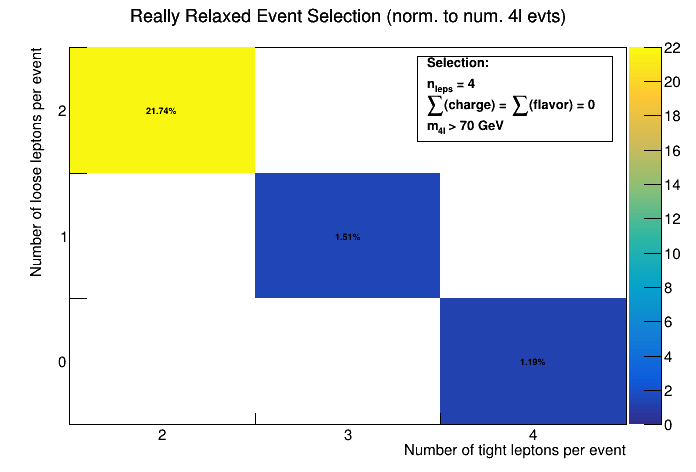

In [48]:
canv, pave = draw_th2(h2_nlooseleps_vs_ntightleps_reallyrelaxed_normto4levts, as_percent=True, z_max=22, , selec="relax")

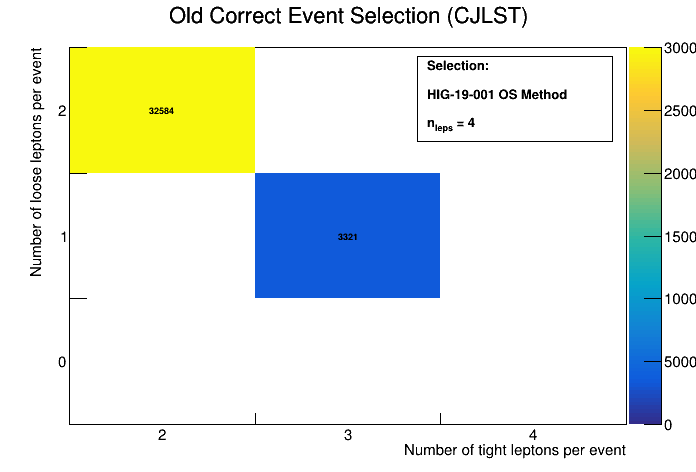

In [107]:
canv, pave = draw_th2(h2_nlooseleps_vs_ntightleps, as_percent=False, z_max=30000, selec="cjlst")

In [109]:
canv.Print("/cmsuf/data/store/user/t2/users/rosedj1/ZplusXpython/sidequests/data2018_h2_numlooseleps_vs_numtightleps_cjlstevtselec.pdf")

Info in <TCanvas::Print>: pdf file /cmsuf/data/store/user/t2/users/rosedj1/ZplusXpython/sidequests/data2018_h2_numlooseleps_vs_numtightleps_cjlstevtselec.pdf has been created


In [103]:
# Scale by the number of events in Really Relaxed Event Selection.
h2_nlooseleps_vs_ntightleps_cjlst_evtsel = h2_nlooseleps_vs_ntightleps.Clone()
h2_nlooseleps_vs_ntightleps_cjlst_evtsel_normtorelaxed = h2_nlooseleps_vs_ntightleps_cjlst_evtsel.Divide(h2_nlooseleps_vs_ntightleps_reallyrelaxed)
h2_nlooseleps_vs_ntightleps_cjlst_evtsel_normtorelaxed.Scale(100.0)

AttributeError: 'bool' object has no attribute 'Scale'

Error in <TH2F::Divide>: Cannot divide histograms with different number of bins


In [93]:
    #--- Save/Open 2-D hists. ---#
    f_new = TFile.Open("h2_nlooseleps_vs_ntightleps_cjlst_evtsel.root", "recreate")
    h2_nlooseleps_vs_ntightleps.Write()
    f_new.Close()

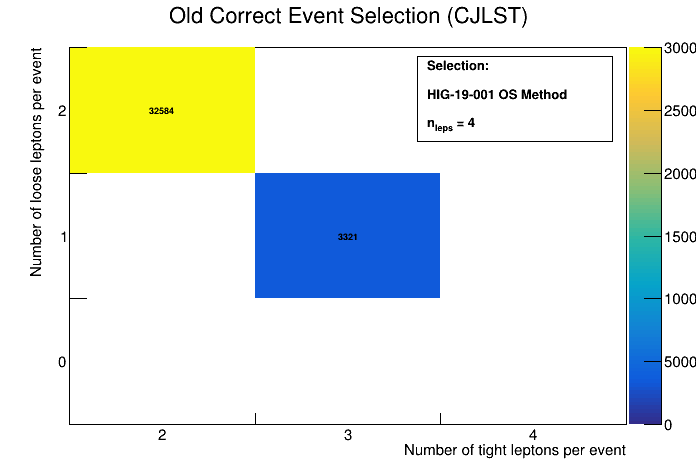

In [108]:
canv.Draw()